# Capstone Project 
## Applied Data Science Capstone by IBM/Coursera

### Introduction: Description of the problem

In this project, I will try to attempt to identify a probable area to set up a restaurant in London city. I will try to identify specific area and location where a restaurant might be of interest for stakeholders. This is partly based on the lessons that were part of Data Science course and the Berlin City example provided in the course.

London has about 33 boroughs, including City of London. There are about 533 neighbourhoods. Ideally, I would have wanted to survey all the neighbourhoods, but considering limitations on the sandbox account of Foursquare, I will limit the study to about 6000 metres radius of London (51.5073219, -0.1276474).

The neighbourhoods of the London will not be specifically considered. The region under 6000 metres radius of London is divided into several areas to begin the survey of restaurants located using Foursquare. I will try to identify specific cuisine restaurant in an area based on its frequency.




### Data Sources:

The neighbhourhood and borough locations have been scrapped from below wikipedia link using Beautiful Soup.
https://en.wikipedia.org/wiki/List_of_areas_of_London

The borough boundaries have been taken from below link.Though borough boundaries are not utilised for analysis, but have been used for general visualisation purpose.
https://github.com/martinjc/UK-GeoJSON/blob/master/json/administrative/eng/lad.json


### Factors that might affect the selection:

1.number of existing restaurants in a restaurant 
2.frequency of specific restaurants 
3.distance to city centre 
4.population of the area 

Points 1 to 3 are considered in this report scope. Point-4 can be considered for the future scope.



### Below Code Scrapes the boroughs and neighbhourhoods of London City

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas import ExcelWriter
import json
from pandas.io.json import json_normalize

response_can=requests.get("https://en.wikipedia.org/wiki/List_of_areas_of_London")
soup = BeautifulSoup(response_can.text,"html.parser")
Table_Rows = soup.find_all("tr")

Neighbhorhood=[]
Borough=[]
PostTown=[]
PostCode=[]
DialCode=[]
Coords=[]


for i in range(3,536):

    x=Table_Rows[i].find_all("td")
    
    neighbhorhood = x[0].find("a").text.strip()
    Neighbhorhood.append(neighbhorhood)
    
    try:
        borough =   x[1].text.strip().strip(x[1].find("a").text).strip()
        
    except:
        borough =   x[1].text.strip()
    Borough.append(borough)
    
    postTown =      x[2].text.strip()
    PostTown.append(postTown)
    
    postCode =      x[3].text.strip()
    PostCode.append(postCode)
    
    dialCode =      x[4].text.strip()
    DialCode.append(dialCode)
    
    coord_strip1= len('https://tools.wmflabs.org/geohack/en/')
    coord_strip2=len('_region:GB_scale:25000?pagename=List_of_areas_of_London')
    try:
        coords=         x[5].find("a")['href'][coord_strip1:-coord_strip2].split(';')
        lat = coords[0]
        long = coords[1]
    except:
        coords= 'NAN' 
    Coords.append(coords)
    
Df_London = pd.DataFrame({'Neighbhorhood':Neighbhorhood,'Borough':Borough,'PostTown':PostTown,'Post Code':PostCode,'Dial Code':DialCode,'Coords':Coords})

print('Number of Neighbhourhoods in London: ',  Df_London.shape[0])

Borough_list =['Croydon' ,'Bexley' ,'Redbridge' ,'City' ,'Westminster' ,'Brent', 'Bromley', 'Islington', 'Havering' ,'Barnet', 'Enfield', 'Wandsworth' ,'Southwark',
 'Barking and Dagenham' ,'Richmond upon Thames' ,'Newham' ,'Sutton' ,'Ealing', 'Lewisham' ,'Harrow' ,'Camden', 'Kingston upon Thames', 'Tower Hamlets',
 'Greenwich', 'Haringey', 'Hounslow' ,'Lambeth', 'Waltham Forest', 'Merton' ,'Hillingdon', 'Hackney', 'Kensington and Chelsea','Hammersmith and Fulham',]


DF = Df_London[ (Df_London['Coords'] !='NAN') & (~Df_London['Borough'].str.contains(',')) & (Df_London['Borough'].isin(Borough_list))].reset_index(drop=True)

print('Number of Neighbhourhoods Plotted in London Map after filtering: ', (DF.shape)[0])

DF.head()

Number of Neighbhourhoods in London:  533
Number of Neighbhourhoods Plotted in London Map after filtering:  500


,Neighbhorhood,Borough,PostTown,Post Code,Dial Code,Coords
0,Addington,Croydon,CROYDON,CR0,020,"[51.362931128458, -0.026373738779412]"
1,Addiscombe,Croydon,CROYDON,CR0,020,"[51.381621885559, -0.068682165650808]"
2,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,"[51.434925966837, 0.12492137518833]"
3,Aldborough Hatch,Redbridge,ILFORD,IG2,020,"[51.585577492045, 0.098742119839992]"
4,Aldgate,City,LONDON,EC3,020,"[51.51488143102, -0.078904677469267]"


### Below Code marks the borough boundaries(green), neighbhourhoods centres(red) and 6000 metres region (blue) of interest.

In [2]:
import folium
from geopy.geocoders import Nominatim
address = 'London'
geolocator = Nominatim(user_agent="london")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

map_london = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.Marker([latitude,longitude], popup='London_Centre').add_to(map_london)
i=0
for coord, borough, neighborhood in zip(DF['Coords'], DF['Borough'], DF['Neighbhorhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(coord[0].strip()), float(coord[1].strip())],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(map_london)
    folium.Circle([float(coord[0].strip()), float(coord[1].strip())], radius=300, color='red', fill=False).add_to(map_london)
    
with open('London.json', 'r') as myfile:
    London_Borough=myfile.read()

def boroughs_style(feature):
    return { 'color': 'green', 'fill': False }

folium.GeoJson(London_Borough, style_function=boroughs_style, name='geojson').add_to(map_london)
folium.Circle([latitude, longitude], radius=6000, color='blue', fill=False).add_to(map_london)
map_london

The geograpical coordinate of London are 51.5073219, -0.1276474.


### Below code divides the 6000m region into several areas and area centres are extracted

In [7]:
import math
from geopy import distance

London_Coords = [51.5073219,-0.1276474]

Search_Radius = 6600
Area_diameter = 600

latitudes= []
longitudes = []
Distance_Centre =[]

Dy=[Area_diameter,-Area_diameter,Area_diameter,-Area_diameter]
Dx=[Area_diameter,-Area_diameter,-Area_diameter,Area_diameter]


for dx,dy in zip(Dx,Dy):
    for i in range(int(Search_Radius/Area_diameter)+1):
        lat=i*dy/(111.3195*1000) + London_Coords[0]    
        for j in range(int(Search_Radius/Area_diameter)+1):
            long= London_Coords[1] - j*dx/((111.3195*1000)*math.cos(London_Coords[0]*3.14159/180))
            latitudes.append(lat)
            longitudes.append(long)


Actual_centres = list(zip(latitudes,longitudes))         
lat_long_centres = list(dict.fromkeys(Actual_centres))

Final_Area_coord=[]
for coord in lat_long_centres:
    distance_from_centre = distance.distance((London_Coords[0],London_Coords[1]), coord).m
    if distance_from_centre <= 6300:
        Final_Area_coord.append(coord)
        Distance_Centre.append(distance_from_centre)


map_london = folium.Map(location=[London_Coords[0], London_Coords[1]], zoom_start=12)
folium.Circle([London_Coords[0], London_Coords[1]], radius=6000, color='blue', fill=False).add_to(map_london)
folium.Marker([London_Coords[0],London_Coords[1]], popup='London_Centre').add_to(map_london)

for coord,num in zip(Final_Area_coord,range(len(Final_Area_coord))):
    folium.CircleMarker([coord[0], coord[1]], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london) 
    folium.Circle([coord[0], coord[1]], radius=Area_diameter/2, color='blue', fill=False).add_to(map_london)
    folium.Marker(location=[coord[0], coord[1]],
                      icon=folium.DivIcon(html=f"""<div style="color: 'green';">{num}</div>""")
                      ).add_to(map_london) 

latitudes_final= [coord[0] for coord in Final_Area_coord]
longitudes_final = [coord[1] for coord in Final_Area_coord]
Area_No= [x for x in range(len(latitudes_final))]

Actual_area_details = pd.DataFrame({'Area No.':Area_No,'latitudes_final':latitudes_final,'longitudes_final':longitudes_final,'Distance from Center':Distance_Centre})
print('Total listed areas in the 6000m radius: ',len(Final_Area_coord))
print(Actual_area_details.head())
map_london

Total listed areas in the 6000m radius:  349
   Area No.  latitudes_final  longitudes_final  Distance from Center
0         0        51.507322         -0.127647              0.000000
1         1        51.507322         -0.136307            601.233466
2         2        51.507322         -0.144967           1202.466930
3         3        51.507322         -0.153626           1803.700390
4         4        51.507322         -0.162286           2404.933843


### Below code extracts All number of Food Places in 6000m radius

In [5]:
import requests
from pandas.io.json import json_normalize

CLIENT_ID = '---------------------------' #  Foursquare ID
CLIENT_SECRET = '------------------------------' #  Foursquare Secret
VERSION = '20180605' # Foursquare API version


LIMIT = 100
search_radius = 430 # more than 300m, in order to overlap, so that non intersected areas are also searched.

category_food_id='4d4b7105d754a06374d81259' # All food category


def getNearbyFood(names, latitudes, longitudes, radius=search_radius):
    
    food_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
 
            
        # create the API request URL
        url1 = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,category_food_id,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url1).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        food_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results])

    nearby_food = pd.DataFrame([item for rl in food_list for item in rl])
    nearby_food.columns = ['Circle No.', 
                  'Circle Latitude', 
                  'Circle Longitude', 
                  'Restaurant Name', 
                  'Restaurant Latitude', 
                  'Restaurant Longitude', 
                  'Restaurant Category','Restaurant Category ID' ]
    
    return(nearby_food)

All_Food = getNearbyFood(names=range(len(latitudes_final)),
                                   latitudes=latitudes_final,
                                   longitudes=longitudes_final
                                  )


All_Food_unique = All_Food.drop_duplicates(subset='Restaurant Latitude', keep ='first')

print('Total Food Places in 6000m radius:' , All_Food_unique.shape[0])
All_Food_unique.head()

Total restaurants in 6000m radius: 5666


,Circle No.,Circle Latitude,Circle Longitude,Restaurant Name,Restaurant Latitude,Restaurant Longitude,Restaurant Category,Restaurant Category ID
0,0,51.507322,-0.127647,Barrafina,51.509427,-0.125894,Spanish Restaurant,4bf58dd8d48988d150941735
1,0,51.507322,-0.127647,Tandoor Chop House,51.509192,-0.125638,North Indian Restaurant,54135bf5e4b08f3d2429dfdd
2,0,51.507322,-0.127647,Bancone,51.509529,-0.126434,Italian Restaurant,4bf58dd8d48988d110941735
3,0,51.507322,-0.127647,Thai Square,51.507656,-0.129830,Thai Restaurant,4bf58dd8d48988d149941735
4,0,51.507322,-0.127647,Kerridge’s Bar & Grill,51.506728,-0.124520,Restaurant,4bf58dd8d48988d1c4941735


### Some clean up, to identify only restaurants

Below code removes the food places that generally are not classified as restaurants.
Italian restaurant is chosen out of interest to see how it fares with general restaurants. It is observed that Italian restaurants are about % of the total restaurants.


In [11]:
Not_Restaurants = ['Bakery','Bagel Shop' ,'Cafe','Cafeteria', 'Coffee Shop','Donut Shop','Pet Cafe']
Italian_Restaurant = ['Italian Restaurant']

All_Restaurants = All_Food_unique[~All_Food_unique['Restaurant Category'].isin(Not_Restaurants)]
All_Italian_Restaurants = All_Food_unique[All_Food_unique['Restaurant Category'].isin(Italian_Restaurant)]
print('Total Number of Restaurants: ',All_Restaurants.shape[0])
print('Total Number of Italian Restaurants: ',All_Italian_Restaurants.shape[0])

Total Number of Restaurants:  5378
Total Number of Italian Restaurants:  426


### Plotting all restaurants

Below code could not render all the points. I have inserted the map (ran outside jupyter) as an image below the code.

In [14]:
#London Coordinates
latitude = 51.5073219
longitude = -0.1276474

map_london_res = folium.Map(location=[latitude, longitude], zoom_start=12)
folium.Marker([latitude,longitude], popup='London_Centre').add_to(map_london)

for num,clat,clong,rlat, rlong, rcat  in zip(All_Restaurants['Circle No.'],All_Restaurants['Circle Latitude'], All_Restaurants['Circle Longitude'],All_Restaurants['Restaurant Latitude'], All_Restaurants['Restaurant Longitude'], All_Restaurants['Restaurant Category']):
    
    if rcat == 'Italian Restaurant':
        folium.CircleMarker(
            [rlat, rlong],
            radius=2,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.2,
            parse_html=False).add_to(map_london_res)
    else:
        folium.CircleMarker(
            [rlat, rlong],
            radius=2,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.2,
            parse_html=False).add_to(map_london_res)

        
for num,clat,clong in zip(Actual_area_details['Area No.'],Actual_area_details['latitudes_final'],Actual_area_details['longitudes_final']):
    
    folium.Circle([clat, clong], radius=300, color='green', fill=False).add_to(map_london_res)
    folium.Marker(location=[clat,clong],
                      icon=folium.DivIcon(html=f"""<div style="color: 'green';">{num}</div>""")
                      ).add_to(map_london_res)
    
map_london_res

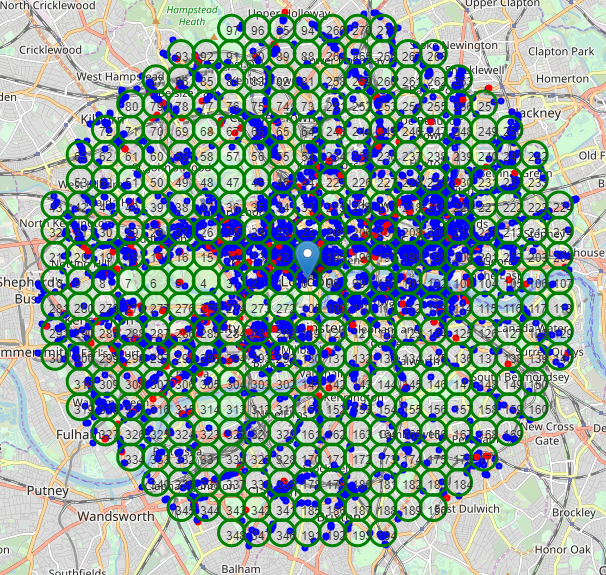

In [15]:
from IPython.display import Image
Image("Restaurants.png")

####  Areas 120 to 194 are identified.

If the above map is to be divided into four quadrants,On closer look it can be seen that Sout-East quadrant areas (120 to 194) have some low restaurant density.

In [20]:
Areas_120_194=Actual_area_details.loc[(Actual_area_details['Area No.']>=120) & (Actual_area_details['Area No.']<195)].reset_index(drop=True)
Areas_120_194.head()

,Area No.,latitudes_final,longitudes_final,Distance from Center
0,120,51.496542,-0.118988,1341.630714
1,121,51.496542,-0.110328,1698.432777
2,122,51.496542,-0.101668,2166.219923
3,123,51.496542,-0.093009,2687.652790
4,124,51.496542,-0.084349,3236.909044


The Area centre coordinates are converted to UTM system in order to be utilised by the clustering algorithm.

In [21]:
import utm

Areas_120_194['UTM']= [utm.from_latlon(lat, long) for lat,long in zip(Areas_120_194['latitudes_final'],Areas_120_194['longitudes_final'])]
Areas_120_194['X_UTM'] =[utm[0] for utm in Areas_120_194['UTM']]
Areas_120_194['Y_UTM'] =[utm[1] for utm in Areas_120_194['UTM']]
Areas_120_194.head()

,Area No.,latitudes_final,longitudes_final,Distance from Center,UTM,X_UTM,Y_UTM
0,120,51.496542,-0.118988,1341.630714,"(699975.1908041856, 5708980.605920916, 30, U)",699975.190804,5.708981e+06
1,121,51.496542,-0.110328,1698.432777,"(700576.1544680566, 5709004.309551334, 30, U)",700576.154468,5.709004e+06
2,122,51.496542,-0.101668,2166.219923,"(701177.1171001615, 5709028.084402835, 30, U)",701177.117100,5.709028e+06
3,123,51.496542,-0.093009,2687.652790,"(701778.0786973713, 5709051.930476144, 30, U)",701778.078697,5.709052e+06
4,124,51.496542,-0.084349,3236.909044,"(702379.0392565564, 5709075.847771986, 30, U)",702379.039257,5.709076e+06


## Clusters

Having identified the areas, Below I am running the Kmeans Cluster algorithm to identify possible cluster centres.
The cluster centers and addresses will be the final output.

In [66]:
from sklearn.cluster import KMeans

number_of_clusters = 15

Probable_Areas = Areas_120_194[['X_UTM', 'Y_UTM']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(Probable_Areas)
cluster_centers = [utm.to_latlon(x[0], x[1],30,'U') for x in kmeans.cluster_centers_]
print('Cluster centres:\n', cluster_centers)

Cluster centres:
 [(51.472287688040886, -0.08867806517822707), (51.48145050392093, -0.05490556556935111), (51.46689779615767, -0.10599736041460472), (51.494386338845246, -0.10859513022768486), (51.494386343482226, -0.0860802912009282), (51.48576249255598, -0.12146101964298683), (51.45611801360066, -0.10599735952796419), (51.46150790548307, -0.08867806427586489), (51.47067072067739, -0.07222486065227196), (51.49384725482956, -0.045379826948949376), (51.49205069743514, -0.06558581426478804), (51.48037263263931, -0.10166782952892905), (51.4825285791318, -0.07742039696923175), (51.46959274213416, -0.12331666139846575), (51.45611801303137, -0.12331665502405231)]


### Maping the clusters

In [58]:
map_london_c = folium.Map(location=[latitude, longitude], zoom_start=13)

for clalong,lab in zip(cluster_centers,range(len(cluster_centers))):
    folium.Marker(location=[clalong[0],clalong[1]],popup=str(lab)).add_to(map_london_c)
                  
                  
                  
for clat,clong,num in zip(Areas_120_194['latitudes_final'],Areas_120_194['longitudes_final'],Areas_120_194['Area No.']):
    folium.Circle([clat, clong], radius=300, color='green', fill=False).add_to(map_london_c)
    folium.Marker(location=[clat, clong],
                  icon=folium.DivIcon(html=f"""<div style="color: 'green';">{num}</div>""")).add_to(map_london_c)
                  
map_london_c

### Addresses of the possible search locations

In [64]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Capstone")

print("----------------Search Locations to set up a Restaurant-----------\n")
for clust,i in enumerate(cluster_centers,1):
    #print(i[0])
    location = geolocator.reverse(i[0], i[1])
    Address = location.address.replace(", United Kingdom","").replace(", England","")
    print('{}. {}'.format(clust,Address))

----------------Search Locations to set up a Restaurant-----------

1. Royal Borough of Greenwich, London, Greater London
2. Children's play area, Park Vista, East Greenwich, Royal Borough of Greenwich, London, Greater London, SE10 9LY
3. 18, Baizdon Road, Blackheath Vale, Blackheath, London Borough of Lewisham, London, Greater London, SE3 0US
4. GR40, Tunnel Avenue, Greenwich Peninsula, Royal Borough of Greenwich, London, Greater London, SE10 0PT
5. GR40, Tunnel Avenue, Greenwich Peninsula, Royal Borough of Greenwich, London, Greater London, SE10 0PT
6. Lassell Street, East Greenwich, Royal Borough of Greenwich, London, Greater London, SE10 9GL
7. 4-20, Northbrook Road, Blackheath Vale, Hither Green, London Borough of Lewisham, London, Greater London, SE13 5QT
8. 2-14, Blessington Road, Blackheath Vale, Blackheath, London Borough of Lewisham, London, Greater London, SE13 5ED
9. Whitfield's Mound, Goffers Road, Blackheath Vale, Blackheath, London Borough of Lewisham, London, Greater Lo

## Conclusion and Discussion

It is observed that broadly, Royal Borough of Greenwich and London Borough of Lewisham are good boroughs to search for a restaurant location.
There are several factors that go into decision making. 
The above analysis is pretty basic and is based on simple restaurant density in the area.

Future work can include population, income etc layers on to the existing one.